In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms  

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
 

In [2]:
 # 这句用来设置pytorch在哪运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数设置
num_epochs = 5
num_classes = 10
batch_size = 64  # 一个batch 的大小
image_size = 28  #图像的总尺寸28*28
learning_rate = 0.001

In [3]:

train_dataset = torchvision.datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True) 
test_dataset = torchvision.datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

100.1%

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


113.5%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


100.4%

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


180.4%D:\python\anconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
print('len(train_loader):',len(train_loader))
print('len(train_loader.dataset):',len(train_loader.dataset))

"""
接下来把测试数据中的前5000个样本作为验证集，后5000个样本作为测试集
"""
indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]  

# 通过下标对验证集和测试集进行采样
sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

# 根据采样器来定义加载器，然后加载数据
validation_loader = torch.utils.data.DataLoader(dataset =test_dataset,batch_size = batch_size,sampler = sampler_val)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,sampler = sampler_test)

len(train_loader): 938
len(train_loader.dataset): 60000


标签是： 5


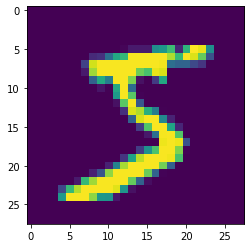

In [105]:
idx = 0

#dataset支持下标索引，其中提取出来的每一个元素为features，target格式，即属性和标签。[0]表示索引features
muteimg = train_dataset[idx][0].numpy()
#由于一般的图像包含rgb三个通道，而MINST数据集的图像都是灰度的，只有一个通道。因此，我们忽略通道，把图像看作一个灰度矩阵。

#用imshow画图，会将灰度矩阵自动展现为彩色

plt.imshow(muteimg[0,...])
print('标签是：',train_dataset[idx][1])

In [106]:
#定义两个卷积层的厚度（feature map的数量）
depth = [4, 4]
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,depth[0],5,padding=2) # 1 input channel, 8 output channels, 5x5 square convolution kernel
        self.pool = nn.MaxPool2d(2, 2) #定义一个Pooling层
        self.conv2 = nn.Conv2d(depth[0],depth[1],5, padding = 2) #第二层卷积:8input channel, 4 output channels, 5x5 square convolution kernel
        self.fc1 = nn.Linear( depth[1] * image_size // 4 * image_size // 4 , 512) #线性连接层的输入尺寸为最后一层立方体的平铺，输出层512个节点
        self.fc2 = nn.Linear(512, num_classes) #最后一层线性分类单元，输入为512，输出为要做分类的类别数  
        
    def forward(self, x):
        # x尺寸：(batch_size, image_channels, image_width, image_height)
        x = F.relu(self.conv1(x))  #第一层卷积的激活函数用ReLu
        x = self.pool(x) #第二层pooling，将片变小
        
        #x的尺寸：(batch_size, depth[0], image_width/2, image_height/2)
        x = F.relu(self.conv2(x)) #第三层卷积，输入输出通道分别为depth[0]=4, depth[1]=8
        x = self.pool(x) #第四层pooling，将图片缩小到原大小的1/4
        
        #x的尺寸：(batch_size, depth[1], image_width/4, image_height/4)
        # view函数将张量x变形成一维的向量形式，总特征数batch_size * (image_size//4)^2*depth[1]不改变，为接下来的全连接作准备。
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
        #x的尺寸：(batch_size, depth[1]*image_width/4*image_height/4)
        x = F.relu(self.fc1(x)) #第五层为全链接，ReLu激活函数
        
        #x的尺寸：(batch_size, 512)
        # dropout 参数training：pply dropout if is True. Defualt: True
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作，为了防止过拟合
        x = self.fc2(x) 
        
        #x的尺寸：(batch_size, num_classes)
        #输出层为log_softmax，即概率对数值log(p(x))。采用log_softmax可以使得后面的交叉熵计算更快
        #log_softmax虽然等价于log(softmax(x))，但是分开两个运算会速度比较慢，数值也不稳定。
        # dim=0 ，即softmax后横向的和为1
        x = F.log_softmax(x, dim = 0) 
        return x
    
    def retrieve_features(self, x):
        #该函数用于提取卷积神经网络的特征图的功能，返回feature_map1, feature_map2为前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x)) #完成第一层卷积
        x = self.pool(feature_map1)  # 完成第一层pooling
        #print('type(feature_map1)=',feature_map1)
        #type是一个四维的tensor
        feature_map2 = F.relu(self.conv2(x)) #第二层卷积，两层特征图都存储到了feature_map1, feature_map2中
        return (feature_map1, feature_map2)

In [107]:
def accuracy(predictions, labels):
    # torch.max的输出：out (tuple, optional维度) – the result tuple of two output tensors (max, max_indices)
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    right_num = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return right_num, len(labels) #返回正确的数量和这一次一共比较了多少元素

Epoch [1/5] [0/60000]	Loss: 2.298919	训练集准确率: 15.62%	验证集准确率: 14.10%
Epoch [1/5] [6400/60000]	Loss: 2.301183	训练集准确率: 10.83%	验证集准确率: 26.22%
Epoch [1/5] [12800/60000]	Loss: 2.290984	训练集准确率: 12.95%	验证集准确率: 40.08%
Epoch [1/5] [19200/60000]	Loss: 2.287848	训练集准确率: 15.92%	验证集准确率: 52.52%
Epoch [1/5] [25600/60000]	Loss: 2.249463	训练集准确率: 19.58%	验证集准确率: 59.86%
Epoch [1/5] [32000/60000]	Loss: 2.197756	训练集准确率: 23.53%	验证集准确率: 61.62%
Epoch [1/5] [38400/60000]	Loss: 1.852088	训练集准确率: 27.68%	验证集准确率: 63.86%
Epoch [1/5] [44800/60000]	Loss: 1.168872	训练集准确率: 32.25%	验证集准确率: 74.26%
Epoch [1/5] [51200/60000]	Loss: 0.817512	训练集准确率: 36.91%	验证集准确率: 79.14%
Epoch [1/5] [57600/60000]	Loss: 0.786448	训练集准确率: 41.24%	验证集准确率: 82.02%
Epoch [2/5] [0/60000]	Loss: 0.682452	训练集准确率: 81.25%	验证集准确率: 82.82%
Epoch [2/5] [6400/60000]	Loss: 0.810404	训练集准确率: 79.89%	验证集准确率: 83.82%
Epoch [2/5] [12800/60000]	Loss: 0.532311	训练集准确率: 81.56%	验证集准确率: 85.34%
Epoch [2/5] [19200/60000]	Loss: 0.419761	训练集准确率: 81.99%	验证集准确率: 85.88%
Epoch [2/5] [256

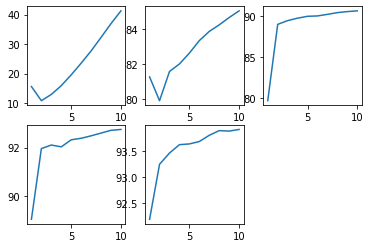

In [108]:
net = ConvNet()

criterion = nn.CrossEntropyLoss() #Loss函数的定义，交叉熵
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #定义优化器，普通的随机梯度下降算法

record = [] #记录训练集和验证集上错误率的list
weights = [] #每若干步就记录一次卷积核
fig=plt.figure()
for epoch in range(num_epochs):
    train_accuracy = [] #记录训练数据集准确率的容器
    los_list=[]
    accu=[]
    # 一次迭代一个batch的 data 和 target
    for batch_id, (data,target) in enumerate(train_loader):
        net.train() # 给网络模型做标记，打开关闭net的training标志,从而决定是否运行dropout
        
        output =  net(data) #forward 
        loss = criterion(output, target) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accuracies = accuracy(output, target)
        train_accuracy.append(accuracies)
        
        if batch_id%100 ==0: #每间隔100个batch执行一次打印等操作
            net.eval() # 给网络模型做标记，将模型转换为测试模式。
            val_accuracy = [] #记录校验数据集准确率的容器            
            for (data, target) in validation_loader: #计算校验集上面的准确度
                output = net(data) #完成一次前馈计算过程，得到目前训练得到的模型net在校验数据集上的表现
                accuracies = accuracy(output, target) #计算准确率所需数值，返回正确的数值为（正确样例数，总样本数）
                val_accuracy.append(accuracies)                
            # 分别计算在已经计算过的训练集，以及全部校验集上模型的分类准确率            
            #train_r为一个二元组，分别记录目前  已经经历过的所有  训练集中分类正确的数量和该集合中总的样本数，
            train_r = (sum([tup[0] for tup in train_accuracy]), sum([tup[1] for tup in train_accuracy]))
            #val_r为一个二元组，分别记录校验集中分类正确的数量和该集合中总的样本数
            val_r = (sum([tup[0] for tup in val_accuracy]), sum([tup[1] for tup in val_accuracy]))
            los_list.append(100. * val_r[0] / val_r[1])
            #打印准确率等数值，其中正确率为本训练周期Epoch开始后到目前batch的正确率的平均值
            print('Epoch [{}/{}] [{}/{}]\tLoss: {:.6f}\t训练集准确率: {:.2f}%\t验证集准确率: {:.2f}%'.format(
                epoch+1,num_epochs, batch_id * batch_size, len(train_loader.dataset),
                loss.item(), 
                100. * train_r[0] / train_r[1], 
                100. * val_r[0] / val_r[1]))            
            #将准确率和权重等数值加载到容器中，方便后续处理            
            record.append((100 - 100. * train_r[0] / train_r[1], 100 - 100. * val_r[0] / val_r[1])) 
            accu.append(100. * train_r[0] / train_r[1])
            # weights记录了训练周期中所有卷积核的演化过程。net.conv1.weight就提取出了第一层卷积核的权重
            # clone的意思就是将weight.data中的数据做一个拷贝放到列表中，否则当weight.data变化的时候，列表中的每一项数值也会联动
            '''这里使用clone这个函数很重要'''
            weights.append([net.conv1.weight.data.clone(), net.conv1.bias.data.clone(), 
                            net.conv2.weight.data.clone(), net.conv2.bias.data.clone()])
    ax=fig.add_subplot(2,3,epoch+1)
    ax.plot(np.arange(1,np.size(accu)+1),accu)

Text(0, 0.5, 'Error rate')

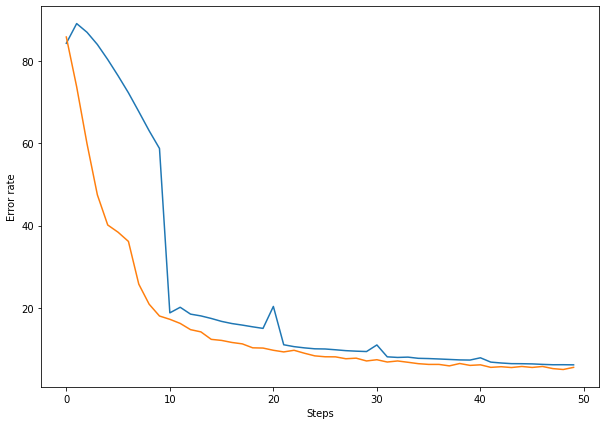

In [109]:
plt.figure(figsize = (10,7))
plt.plot(record)
plt.xlabel('Steps')
plt.ylabel('Error rate')

In [110]:
# 在测试集上进行测试
net.eval() #标志模型当前为测试阶段
vals = [] #记录准确率所用列表

with torch.no_grad():
    for data,target in test_loader:
        
        output = net(data)
        
        val = accuracy(output,target)
        vals.append(val)
        
#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].detach().numpy() / rights[1]


print("test accuracy:",right_rate)

test accuracy: 0.9752


第一层卷积核的最终结果：


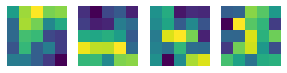

In [111]:
#提取第一层卷积层的卷积核
print('第一层卷积核的最终结果：')
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(1,8,i + 1)
    plt.axis('off')
    plt.imshow(net.conv1.weight.data.numpy()[i,0,...]) #提取第一层卷积核中的权重值，注意conv1是net的属性

卷积核的演变：


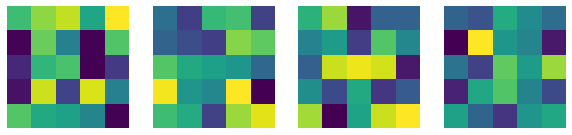

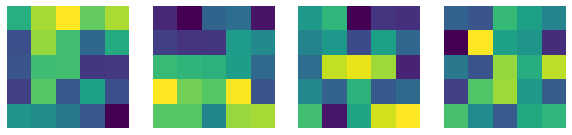

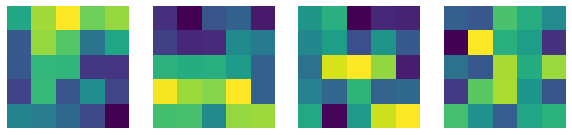

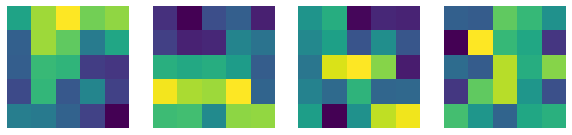

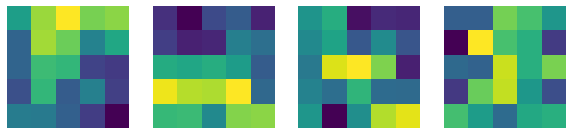

In [112]:
# 将记录在容器中的卷积核权重历史演化数据打印出来
print('卷积核的演变：')
i = 0
for tup in weights:
    if i % 10 == 0 :
        layer1 = tup[0]
        fig = plt.figure(figsize = (10, 7))
        for j in range(4):
            plt.subplot(1, 4, j + 1)
            plt.axis('off')
            plt.imshow(layer1.numpy()[j,0,...])
    i += 1

输入图片为：
卷积层1 的特征图：


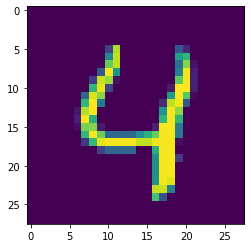

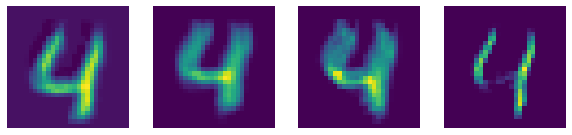

In [113]:
#调用net的retrieve_features方法可以抽取出第一个卷积和第二个卷积层的特征图

#首先定义读入的图片，unsqueeze（0）的作用是在最前面添加一维（batch），让这个input_x的tensor是四维数的，因为conv2d要求输入4参数
idx = 4
input_x = test_dataset[idx][0]
print('输入图片为：')
plt.imshow(input_x[0,...])

input_x = test_dataset[idx][0].unsqueeze(0) 

feature_maps = net.retrieve_features(input_x) #feature_maps是有两个元素的列表，分别表示第一层和第二层卷积的所有特征图

plt.figure(figsize = (10, 7))

#有四个特征图，循环把它们打印出来
print('卷积层1 的特征图：')
for i in range(4):
    plt.subplot(1,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i,...].data.numpy())

第二场卷积核的变化情况：


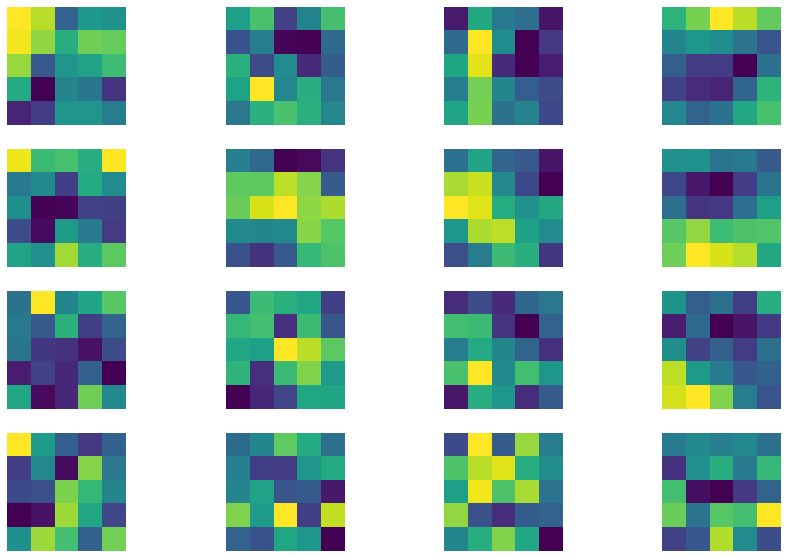

In [114]:
# 绘制第二层的卷积核，每一列对应一个卷积核，一共8个卷积核
print('第二场卷积核的变化情况：')
plt.figure(figsize = (15, 10))
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, i * 4 + j + 1)
        plt.axis('off')
        plt.imshow(net.conv2.weight.data.numpy()[j, i,...])

卷积层2的特征图


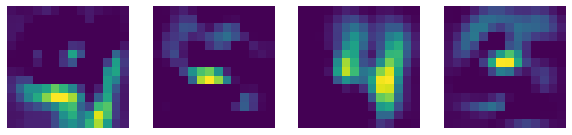

In [115]:
# 绘制第二层的特征图，一共八个
print('卷积层2的特征图')
plt.figure(figsize = (10, 7))
for i in range(4):
    plt.subplot(2,4,i + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i,...].data.numpy())